In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# np.random.seed(0)

In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
cur.execute('''SELECT *
                FROM OrderDetail;''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [4]:
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [5]:
no_discount = df.loc[df['Discount'] == 0]
discount = df.loc[df['Discount']!= 0]
discount.info()
print('**************************')
no_discount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 6 to 2152
Data columns (total 6 columns):
Id           838 non-null object
OrderId      838 non-null int64
ProductId    838 non-null int64
UnitPrice    838 non-null float64
Quantity     838 non-null int64
Discount     838 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 45.8+ KB
**************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 0 to 2154
Data columns (total 6 columns):
Id           1317 non-null object
OrderId      1317 non-null int64
ProductId    1317 non-null int64
UnitPrice    1317 non-null float64
Quantity     1317 non-null int64
Discount     1317 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 72.0+ KB


In [6]:
def get_sample(data, n):
    return list(data.sample(n, replace = False))
    pass
def get_sample_mean(sample):
    return np.mean(sample)
    pass
def create_sample_distribution(data, dist_size=100, n=30):
    sample_means = []
    for i in range(dist_size):
        to_mean = get_sample(data, n)
        sample_means.append(get_sample_mean(to_mean))
    return sample_means
    pass

In [7]:
qty_no_discount = no_discount['Quantity']
qty_discount = discount['Quantity']

Text(0, 0.5, 'Quantity Probability')

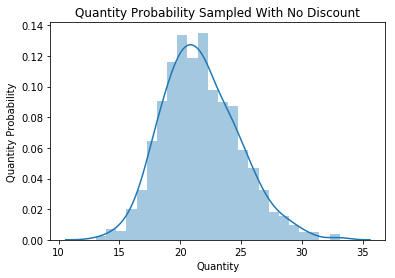

In [8]:
#creation of a sample set for quantity without discounts (grqaph for visualization)
no_discount_sample = create_sample_distribution(qty_no_discount,dist_size=1000,n=30)
sns.distplot(no_discount_sample)
plt.title('Quantity Probability Sampled With No Discount')
plt.xlabel('Quantity')
plt.ylabel('Quantity Probability')

Text(0, 0.5, 'Quantity Probability')

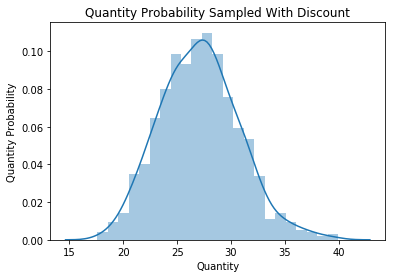

In [9]:
#creation of a sample set for quantity with discounts (grqaph for visualization)
with_discount_sample = create_sample_distribution(qty_discount,dist_size=1000,n=30)
sns.distplot(with_discount_sample)
plt.title('Quantity Probability Sampled With Discount')
plt.xlabel('Quantity')
plt.ylabel('Quantity Probability')

Create sample for z test from the normally distributed samples (now the population total)

In [10]:
#Statistics for the discount quantity sample
disc_total_pop = with_discount_sample
disc_samp = np.random.choice(disc_total_pop, size=30, replace = False)

#Statistics for the no discount quantity sample
no_disc_total_pop = no_discount_sample
no_disc_samp = np.random.choice(no_disc_total_pop, size=30, replace = False)


Summary:
The total population is the population of all quantities

Hypothesis test:

H_0 : mu_1 = mu_2
H1 : mu_1 != mu_2

where mu_1 represents the mean of the no discount data and mu_2 represents the data with a discount

In [19]:
def welch_t(a, b):
    
    """ Calculate Welch's t-statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


t = welch_t(no_disc_samp, disc_samp)
df = welch_df(no_disc_samp, disc_samp)

def p_value(a, b, two_sided=False):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p


p = p_value(no_disc_samp,disc_samp, two_sided = True)


print(t,p)

8.457480507687436 1.2317480369006262e-11


In [22]:
t_stat, p_val = stats.ttest_ind(disc_samp, no_disc_samp)

print('t_stat',t_stat)
print('p_val',p_val)

t_stat 8.457480507687437
p_val 1.0528776488966045e-11


In [15]:
'''# Visualize p_value

def visualize_t(t_stat, n_control, n_experimental):
    
    """
    Visualize the critical t values on a t distribution
    
    Parameters
    -----------
    t-stat: float
    n_control: int
    n_experiment: int
    
    Returns
    ----------
    None
    
    """
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.ppf to get critical value. For alpha = 0.05 and two tailed test
    crit = stats.t.ppf(1-0.025, (n_control+n_experimental-2))
    
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(crit, color='black', linestyle='--', lw=1)
    ax.axvline(-crit, color='black', linestyle='--', lw=1)
    
    plt.show()
    return None

n_control = len(no_disc_samp)
n_experimental = len(disc_samp)
visualize_t(t, n_control, n_experimental)'''

'# Visualize p_value\n\ndef visualize_t(t_stat, n_control, n_experimental):\n    \n    """\n    Visualize the critical t values on a t distribution\n    \n    Parameters\n    -----------\n    t-stat: float\n    n_control: int\n    n_experiment: int\n    \n    Returns\n    ----------\n    None\n    \n    """\n    # initialize a matplotlib "figure"\n    fig = plt.figure(figsize=(8,5))\n    ax = fig.gca()\n    # generate points on the x axis between -4 and 4:\n    xs = np.linspace(-4, 4, 500)\n\n    # use stats.t.ppf to get critical value. For alpha = 0.05 and two tailed test\n    crit = stats.t.ppf(1-0.025, (n_control+n_experimental-2))\n    \n    # use stats.t.pdf to get values on the probability density function for the t-distribution\n    \n    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)\n    ax.plot(xs, ys, linewidth=3, color=\'darkred\')\n\n    ax.axvline(crit, color=\'black\', linestyle=\'--\', lw=1)\n    ax.axvline(-crit, color=\'black\', linestyle=\'--\', lw=1)\n    \